# Assignment 4 - Jackie Woodlief, Jeff Sharpe

### Big Picture
Hard Voting: uses predicted class labels for majority rule voting

Soft Voting: predicts the class label based on the argmax of the sums of the predicted probabilities

For this project we are implementing multiclass classification to determine which of the 9 classes a glacier belongs to (for our dataset, 0-8). We will be doing various data discovery tasks to start with to get a better idea of our data. In particular, we will be plotting the glaciers on a simulated globe based on the given lattitudes and longitudes.

### Get the Data

Dataset: https://www.kaggle.com/nsidcorg/glacier-inventory
Size: 3.2 MB
Entries: 132889
Features: 39

We looked at, and were seriously considering, several data sets. In the end we choose this one because of it's geographic element and the prospects of implementing multi-class classification. Since we have only worked binary classification for the previous assignments, we thought we would try something more advanced. We are also curious as to how accurate the end results will be.

Some of the noticeable stats that you will observe right away is that some of the attributes have a lot of missing values, we'll have to figure out if we should remove those attributes or if it would be better to use an imputer to fill in the missing values. Also, immediately, you can see that some of the attributes are, as they should be, positively correlated, such as longitude and mean elevation accumulation. There are a couple more observations like this that are more-or-less like common sense observations, but it's still good to explore these because it may be unintuitive.

Below is our primary class key, we had to find this data from another source since our data set only gave numbers between 0 and 9 (inclusive).

Primary Class Key:  
0: Uncertain/misc.  
1: Continental Ice Sheet  
2: Ice-field  
3: Ice Cap  
4: Outlet Glacier  
5: Valley Glacier  
6: Mountain Glacier  
7: Snowfield/Glacieret  
8: Ice Shelf  
9: Rock Glacier  

In [1]:
#These are all the import statements!

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier


In [2]:
def plot_dataset(X, y, axes, col1, col2):
    plt.plot(X[:, col1][y==0], X[:, col2][y==0], "gv")
    plt.plot(X[:, col1][y==1], X[:, col2][y==1], "c^")
    plt.plot(X[:, col1][y==2], X[:, col2][y==2], "m<")
    plt.plot(X[:, col1][y==3], X[:, col2][y==3], "yv")
    plt.plot(X[:, col1][y==4], X[:, col2][y==4], "k3")
    plt.plot(X[:, col1][y==5], X[:, col2][y==5], "wo")
    plt.plot(X[:, col1][y==6], X[:, col2][y==6], "bd")
    plt.plot(X[:, col1][y==7], X[:, col2][y==7], "ro")
    plt.plot(X[:, col1][y==8], X[:, col2][y==8], "gd")
    plt.plot(X[:, col1][y==9], X[:, col2][y==9], "gs")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)


In [3]:
#Here we are reading in our dataset

glacier_data = pd.read_csv("database.csv")

/home/shelob/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
glacier_data.head(5)

,Glacier ID,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Glacier Name,Latitude,Longitude,Primary Class,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
0,AF5Q112B0001,AFGHANISTAN,ASIA,Q112,B0,1,NaN,34.672,68.874,9.0,...,1.9,NaN,NaN,NaN,NaN,NE,NE,1959.0,100000.0,NaN
1,AF5Q112B0002,AFGHANISTAN,ASIA,Q112,B0,2,NaN,34.676,68.855,9.0,...,0.8,NaN,NaN,NaN,NaN,NW,NW,1959.0,100000.0,NaN
2,AF5Q112B0003,AFGHANISTAN,ASIA,Q112,B0,3,NaN,34.689,68.854,9.0,...,1.5,NaN,NaN,NaN,NaN,NW,NW,1959.0,100000.0,NaN
3,AF5Q112B0004,AFGHANISTAN,ASIA,Q112,B0,4,NaN,34.707,68.857,9.0,...,1.5,NaN,NaN,NaN,NaN,NE,NE,1959.0,100000.0,NaN
4,AF5Q112B0005,AFGHANISTAN,ASIA,Q112,B0,5,NaN,34.719,68.852,9.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1959.0,100000.0,NaN


In [5]:
glacier_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 39 columns):
Glacier ID                     132890 non-null object
Political Unit                 132890 non-null object
Continent                      132890 non-null object
Basin Code                     132890 non-null object
Location Code                  132890 non-null object
Glacier Code                   132890 non-null object
Glacier Name                   46751 non-null object
Latitude                       132890 non-null float64
Longitude                      132890 non-null float64
Primary Class                  131406 non-null float64
Glacier Source                 132746 non-null float64
Basin Count                    15558 non-null float64
Glacier Form                   131813 non-null float64
Glacier Activity               132775 non-null float64
Activity Start                 4202 non-null float64
Activity End                   143 non-null float64
Minimum Elevation      

In [6]:
glacier_data.describe()

,Latitude,Longitude,Primary Class,Glacier Source,Basin Count,Glacier Form,Glacier Activity,Activity Start,Activity End,Minimum Elevation,...,Mean Width,Mean Length,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Topographic Map Year,Topographic Map Scale,Photograph Year
count,132890.000000,132890.000000,131406.000000,132746.000000,15558.000000,131813.000000,132775.000000,4202.000000,143.000000,117162.000000,...,69966.000000,55258.000000,102593.000000,84621.000000,17051.000000,70071.000000,78685.000000,83697.000000,74586.000000,82464.000000
mean,36.322101,31.902296,5.716231,0.864712,1.031752,3.738918,0.620448,1967.112327,1986.930070,3502.362063,...,0.563436,1.392470,1.417326,1.328634,1.621133,28.415085,2.262960,1970.529565,96838.461508,1974.795899
std,27.821062,83.860643,1.768668,0.494326,0.327473,2.255064,1.072336,11.348193,6.999648,1735.317842,...,0.643816,2.087975,2.560785,1.984061,3.286073,46.480501,0.999009,10.276403,69675.200534,14.107653
min,-71.657200,-179.918000,0.000000,0.000000,1.000000,0.000000,0.000000,1901.000000,1958.000000,0.000000,...,0.000000,0.020000,0.060000,0.000000,0.000000,0.000000,1.000000,1901.000000,750.000000,1900.000000
25%,30.616000,-50.375000,6.000000,1.000000,1.000000,3.000000,0.000000,1963.000000,1986.000000,1800.000000,...,0.300000,0.500000,0.500000,0.500000,0.200000,12.000000,1.000000,1966.000000,50000.000000,1968.000000
50%,38.580000,75.484500,6.000000,1.000000,1.000000,4.000000,0.000000,1967.000000,1986.000000,3840.000000,...,0.400000,0.800000,0.800000,0.800000,0.600000,20.000000,2.000000,1972.000000,90000.000000,1971.000000
75%,49.223000,85.265750,7.000000,1.000000,1.000000,5.000000,1.000000,1975.000000,1988.000000,5020.000000,...,0.700000,1.510000,1.500000,1.500000,2.000000,36.000000,3.000000,1978.000000,100000.000000,1980.000000
max,89.300000,179.680000,9.000000,3.000000,7.000000,9.000000,8.000000,1996.000000,2002.000000,8047.000000,...,29.800000,76.640000,145.000000,125.000000,64.500000,7060.000000,5.000000,1998.000000,1000000.000000,2003.000000


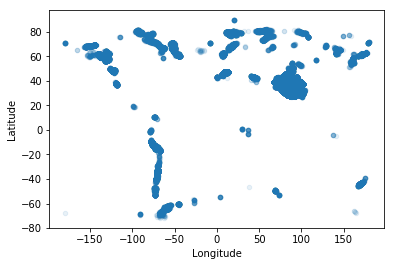

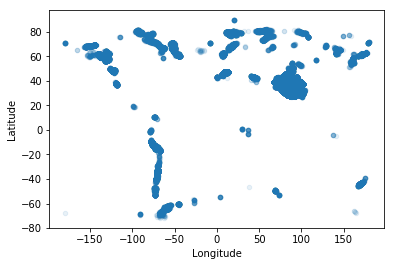

In [8]:
# This is essentially a map of the world! The alpha .1 makes it easier to determine concentrations of glaciers

glacier_data.plot(kind = "scatter", x = "Longitude", y = "Latitude", alpha = .1)
plt.show()

In [ ]:
# Let's see if we can get a better visualization without modifying our data

glacier_data.plot(kind = "scatter", x = "Longitude", y = "Latitude", alpha = .3,
                 s = glacier_data["Glacier Area"], label = "Glacier Area", figsize=(10, 7),
                 c = "Maximum Elevation", cmap = plt.get_cmap("jet"), colorbar = True,
                 )

plt.legend()
plt.show()

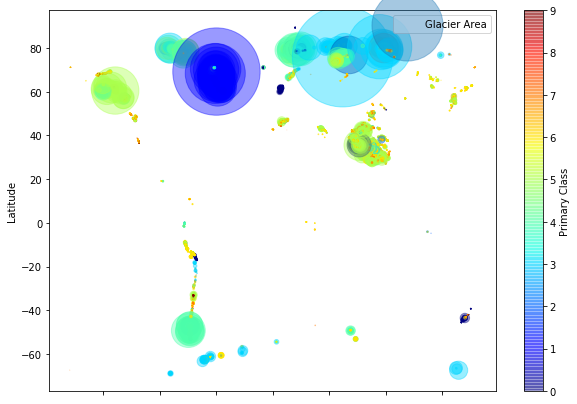

In [ ]:
# Let's try setting our c value to Primary Class, since that will be our multi-class label, and see what happens
# Also, let's try to minimize the size of the circles by dividing glacier area by 1.10

glacier_data.plot(kind = "scatter", x = "Longitude", y = "Latitude", alpha = .4,
                 s = glacier_data["Glacier Area"] / 1.10, label = "Glacier Area", figsize=(10, 7),
                 c = "Primary Class", cmap = plt.get_cmap("jet"), colorbar = True,
                 )

plt.legend()
plt.show()

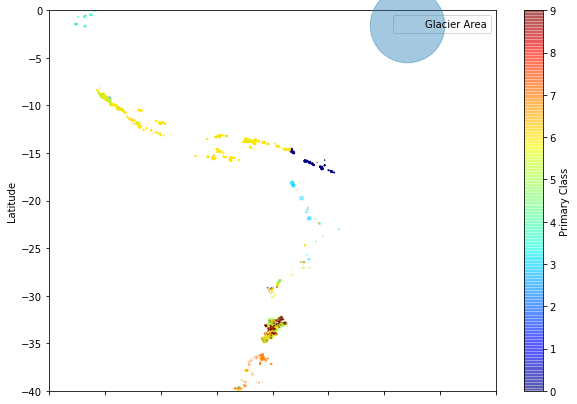

In [11]:
# Now let's see if we can zoom in more on the glaciers in Central / South America area, since they are harder to see
# because the glaciers there typically have less area than elsewhere

glacier_data.plot(kind = "scatter", x = "Longitude", y = "Latitude", alpha = .4,
                 s = glacier_data["Glacier Area"], label = "Glacier Area", figsize=(10, 7),
                 c = "Primary Class", cmap = plt.get_cmap("jet"), colorbar = True,
                 )

plt.axis([-80, -60, -40, 0])
plt.legend()
plt.show()

# Info gained from mapping

We can clearly see that if you go further north or south, you will typically see higher elevation glaciers, as opposed to the ones found closer to the equator. In addition, if we plot based on primary classes (reference the key above for complete details) we realize that the montain and valley glaciers are usually found within countries, as they should be, like US or Canada or India, etc. and we notice that most of the continental ice sheets and ice fields are found very far north. Also those glaciers are bigger than any others, which makes sense. It's nice to be able to graph this data set like this and realize it on a more global scale!

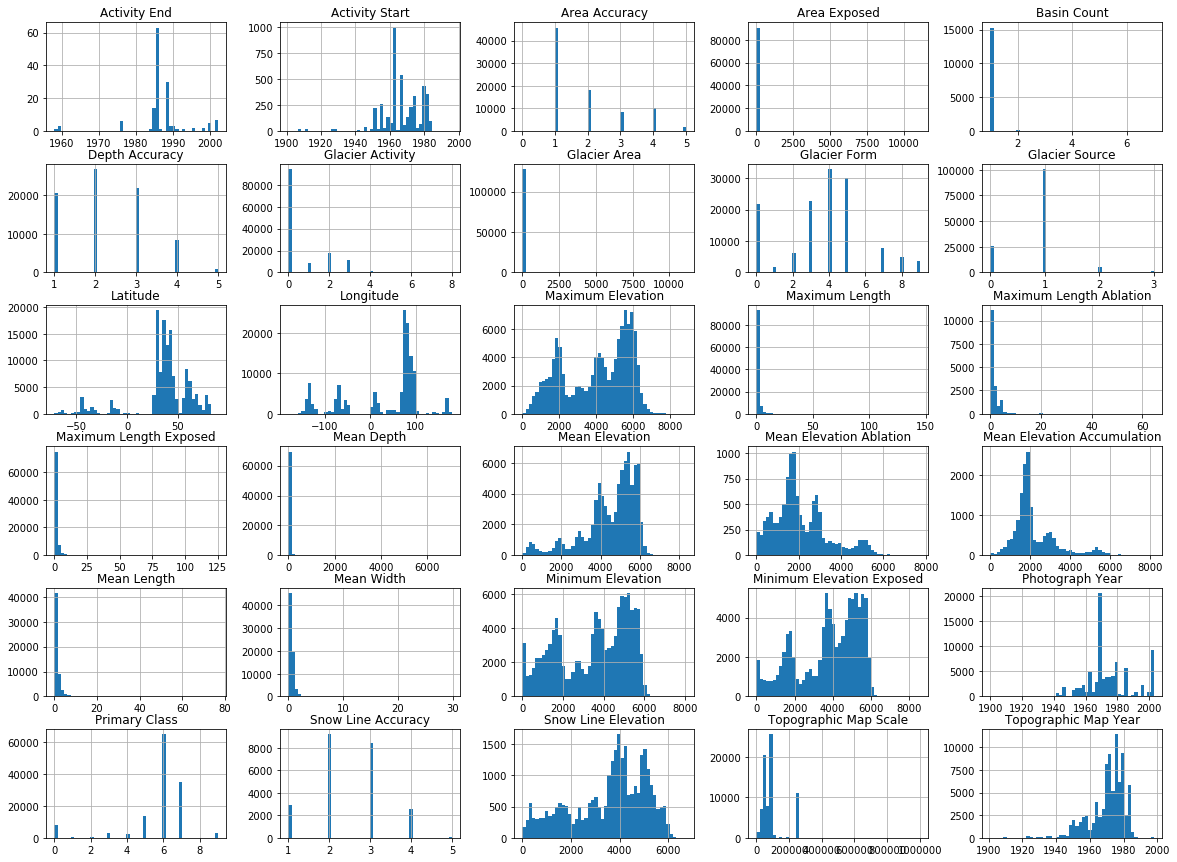

In [9]:
#We should get 30 graphs since 9 of our attributes are objects

%matplotlib inline

glacier_data.hist(bins = 50, figsize = (20, 15))
plt.show()

# Correlation matrix

Let's look at the correlation matrix so far to spot any off-the-bat positive / negative correlations!

In [10]:
corr_1 = glacier_data.corr()

In [11]:
corr_1["Longitude"].sort_values(ascending = False)

Longitude                      1.000000
Mean Elevation Accumulation    0.741467
Mean Elevation Ablation        0.676563
Topographic Map Year           0.587394
Maximum Elevation              0.582169
Minimum Elevation              0.554905
Minimum Elevation Exposed      0.516047
Snow Line Elevation            0.485135
Activity Start                 0.287632
Photograph Year                0.147514
Mean Elevation                 0.082345
Maximum Length                 0.042216
Maximum Length Exposed         0.041488
Mean Depth                     0.036596
Maximum Length Ablation        0.030089
Glacier Form                   0.026804
Glacier Source                 0.019553
Mean Width                     0.010018
Area Exposed                  -0.013882
Glacier Area                  -0.032079
Primary Class                 -0.034855
Basin Count                   -0.040788
Mean Length                   -0.058165
Activity End                  -0.070243
Snow Line Accuracy            -0.111771


In [12]:
corr_1["Maximum Elevation"].sort_values(ascending = False)

Maximum Elevation              1.000000
Mean Elevation Accumulation    0.988700
Mean Elevation                 0.987494
Minimum Elevation              0.974465
Minimum Elevation Exposed      0.973544
Snow Line Elevation            0.953487
Mean Elevation Ablation        0.888271
Longitude                      0.582169
Topographic Map Year           0.563928
Primary Class                  0.195827
Mean Length                    0.127172
Glacier Source                 0.123254
Mean Depth                     0.118157
Maximum Length Exposed         0.105115
Maximum Length Ablation        0.081112
Mean Width                     0.068142
Glacier Form                   0.043632
Maximum Length                 0.042247
Photograph Year                0.029079
Area Exposed                  -0.021727
Glacier Area                  -0.045438
Basin Count                   -0.061318
Snow Line Accuracy            -0.117352
Depth Accuracy                -0.129430
Activity Start                -0.236228


In [13]:
corr_1["Minimum Elevation"].sort_values(ascending = False)

Minimum Elevation              1.000000
Minimum Elevation Exposed      0.999105
Mean Elevation                 0.989034
Maximum Elevation              0.974465
Mean Elevation Accumulation    0.970572
Snow Line Elevation            0.958989
Mean Elevation Ablation        0.894441
Topographic Map Year           0.567582
Longitude                      0.554905
Primary Class                  0.280139
Glacier Source                 0.118960
Glacier Form                   0.111573
Photograph Year                0.049348
Mean Depth                     0.030680
Mean Width                    -0.028512
Maximum Length Exposed        -0.031243
Maximum Length Ablation       -0.037963
Basin Count                   -0.062155
Depth Accuracy                -0.066166
Area Exposed                  -0.077524
Glacier Area                  -0.083443
Mean Length                   -0.089162
Maximum Length                -0.092284
Snow Line Accuracy            -0.109751
Activity Start                -0.162351


In [14]:
#There are no strong correlations with Primary Class, which is good. It means that our dataset is complex!

corr_1["Primary Class"].sort_values(ascending = False)

Primary Class                  1.000000
Glacier Form                   0.492043
Mean Elevation                 0.384576
Minimum Elevation Exposed      0.331970
Minimum Elevation              0.280139
Glacier Source                 0.264868
Maximum Elevation              0.195827
Snow Line Elevation            0.132884
Latitude                       0.124023
Glacier Activity               0.119456
Depth Accuracy                 0.117607
Snow Line Accuracy             0.089764
Mean Elevation Ablation        0.076454
Basin Count                    0.024933
Mean Elevation Accumulation    0.010115
Longitude                     -0.034855
Area Exposed                  -0.040881
Photograph Year               -0.050202
Glacier Area                  -0.074556
Topographic Map Year          -0.083695
Activity Start                -0.098411
Mean Depth                    -0.100419
Activity End                  -0.120568
Topographic Map Scale         -0.122411
Mean Length                   -0.125714


In [15]:
#This is the data that will be used as the multiclass labels, let's take a look at the stats of our future labels

glacier_data["Primary Class"].value_counts().sort_index()

0.0     8209
1.0      267
2.0      682
3.0     2752
4.0     2532
5.0    14002
6.0    65042
7.0    35201
8.0        8
9.0     2711
Name: Primary Class, dtype: int64

# Lastly, to visualize, let's look at some scatter plots

In [28]:
glacier_data.plot(kind = "scatter", x = "Glacier Area", y = "Maximum Elevation")

In [29]:
glacier_data.plot(kind = "scatter", x = "Glacier Area", y = "Minimum Elevation")

In [30]:
glacier_data.plot(kind = "scatter", x = "Latitude", y = "Maximum Elevation")

In [ ]:
glacier_data.plot(kind = "scatter", x = "Longitude", y = "Glacier Area")

# Copying our dataset

Let's copy our data set so that we can refer back to the original at anytime

In [16]:
copy = pd.DataFrame.copy(glacier_data)

# Encoding

There are some attributes that would likely affect the results, such as the ablation orientation (which is the melting of the glacier in a certain direction) and the accumulation orientation (in what direction has the snow accumlated in). In addition to these, other fields that we will encode are the political unit, continent, location, etc. In short, we are encoding the attributes that could affect the results in our favor. Let's go ahead and do that!

In [17]:
encoder = LabelEncoder()

In [18]:
ablation_cat = copy["Ablation Orientation"]
ablation_cat_encoded = encoder.fit_transform(ablation_cat.astype(str))
ablation_cat_encoded

array([2, 3, 3, ..., 8, 6, 7])

In [19]:
accumulation_cat = copy["Accumulation Orientation"]
accumulation_cat_encoded = encoder.fit_transform(accumulation_cat.astype(str))
accumulation_cat_encoded

array([2, 3, 3, ..., 8, 7, 7])

In [20]:
political_cat = copy["Political Unit"]
political_cat_encoded = encoder.fit_transform(political_cat)
political_cat_encoded

array([ 0,  0,  0, ..., 37, 37, 37])

In [21]:
continent_cat = copy["Continent"]
continent_cat_encoded = encoder.fit_transform(continent_cat)
continent_cat_encoded

array([2, 2, 2, ..., 0, 0, 0])

In [22]:
basin_cat = copy["Basin Code"]
basin_cat_encoded = encoder.fit_transform(basin_cat)
basin_cat_encoded

array([402, 402, 402, ...,  26,  26,  26])

In [23]:
location_cat = copy["Location Code"]
location_cat_encoded = encoder.fit_transform(location_cat)
location_cat_encoded

array([206, 206, 206, ..., 173, 174, 175])

In [24]:
glacier_cat = copy["Glacier Code"]
glacier_cat_encoded = encoder.fit_transform(glacier_cat.astype(str))
glacier_cat_encoded

array([  3, 115, 226, ..., 115,   3, 899])

In [25]:
# Now that we have encoded this data, lets replace the attributes in copy with the encoded versions

copy["Ablation Orientation"] = ablation_cat_encoded
copy["Accumulation Orientation"] = accumulation_cat_encoded
copy["Political Unit"] = political_cat_encoded
copy["Continent"] = continent_cat_encoded
copy["Basin Code"] = basin_cat_encoded
copy["Location Code"] = location_cat_encoded
copy["Glacier Code"] = glacier_cat_encoded

In [26]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 39 columns):
Glacier ID                     132890 non-null object
Political Unit                 132890 non-null int64
Continent                      132890 non-null int64
Basin Code                     132890 non-null int64
Location Code                  132890 non-null int64
Glacier Code                   132890 non-null int64
Glacier Name                   46751 non-null object
Latitude                       132890 non-null float64
Longitude                      132890 non-null float64
Primary Class                  131406 non-null float64
Glacier Source                 132746 non-null float64
Basin Count                    15558 non-null float64
Glacier Form                   131813 non-null float64
Glacier Activity               132775 non-null float64
Activity Start                 4202 non-null float64
Activity End                   143 non-null float64
Minimum Elevation           

# Removing some of the attributes

Now that we have converted some of the attributes to int's to aid in our goal of multi-class classification, we can go ahead and remove some of the attributes that will likely not affect our results, attributes such as a glaciers name.

In [27]:
#remove Glacier Name and Glacier ID

copy = copy.drop("Glacier Name", 1)
copy = copy.drop("Glacier ID", 1)

In [28]:
copy.head(5)

,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Latitude,Longitude,Primary Class,Glacier Source,Basin Count,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
0,0,2,402,206,3,34.672,68.874,9.0,0.0,NaN,...,1.9,NaN,NaN,NaN,NaN,2,2,1959.0,100000.0,NaN
1,0,2,402,206,115,34.676,68.855,9.0,0.0,NaN,...,0.8,NaN,NaN,NaN,NaN,3,3,1959.0,100000.0,NaN
2,0,2,402,206,226,34.689,68.854,9.0,0.0,NaN,...,1.5,NaN,NaN,NaN,NaN,3,3,1959.0,100000.0,NaN
3,0,2,402,206,337,34.707,68.857,9.0,0.0,NaN,...,1.5,NaN,NaN,NaN,NaN,2,2,1959.0,100000.0,NaN
4,0,2,402,206,448,34.719,68.852,9.0,0.0,NaN,...,2.0,NaN,NaN,NaN,NaN,8,8,1959.0,100000.0,NaN


# Now we need to focus on cleaning the data we have up

We'll start by getting rid of all of the NaN values in our dataset, we will use the imputer to square this away!

In [29]:
imputer = Imputer(strategy = "median")

In [30]:
imputer.fit(copy)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [31]:
X = imputer.transform(copy)

In [32]:
X.shape

(132890, 37)

In [33]:
transform_copy = pd.DataFrame(X, columns = copy.columns)
transform_copy

,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Latitude,Longitude,Primary Class,Glacier Source,Basin Count,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
0,0.0,2.0,402.0,206.0,3.0,34.672,68.874,9.0,0.0,1.0,...,1.90,0.80,0.6,20.0,2.0,2.0,2.0,1959.0,100000.0,1971.0
1,0.0,2.0,402.0,206.0,115.0,34.676,68.855,9.0,0.0,1.0,...,0.80,0.80,0.6,20.0,2.0,3.0,3.0,1959.0,100000.0,1971.0
2,0.0,2.0,402.0,206.0,226.0,34.689,68.854,9.0,0.0,1.0,...,1.50,0.80,0.6,20.0,2.0,3.0,3.0,1959.0,100000.0,1971.0
3,0.0,2.0,402.0,206.0,337.0,34.707,68.857,9.0,0.0,1.0,...,1.50,0.80,0.6,20.0,2.0,2.0,2.0,1959.0,100000.0,1971.0
4,0.0,2.0,402.0,206.0,448.0,34.719,68.852,9.0,0.0,1.0,...,2.00,0.80,0.6,20.0,2.0,8.0,8.0,1959.0,100000.0,1971.0
5,0.0,2.0,402.0,206.0,564.0,34.806,68.868,9.0,0.0,1.0,...,2.00,0.80,0.6,20.0,2.0,3.0,3.0,1959.0,100000.0,1971.0
6,0.0,2.0,402.0,206.0,676.0,34.818,68.872,9.0,0.0,1.0,...,1.70,0.80,0.6,20.0,2.0,1.0,1.0,1959.0,100000.0,1971.0
7,0.0,2.0,402.0,206.0,787.0,34.802,68.886,9.0,0.0,1.0,...,3.30,0.80,0.6,20.0,2.0,8.0,8.0,1959.0,100000.0,1971.0
8,0.0,2.0,402.0,206.0,899.0,34.807,68.891,9.0,0.0,1.0,...,1.50,0.80,0.6,20.0,2.0,1.0,3.0,1959.0,100000.0,1971.0
9,0.0,2.0,402.0,206.0,4.0,35.175,68.757,9.0,0.0,1.0,...,2.20,0.80,0.6,20.0,2.0,2.0,0.0,1959.0,100000.0,1971.0


In [34]:
# Now let's re-examine the correlation matrix to see if there are any new points of interest

corr_2 = transform_copy.corr()

In [35]:
# When looking at the longitude, we notice that Continent, one of the attributes that we encoded, has a very high
# negative correlation, so it seems like it was worth while to encode a few of the attributes

corr_2["Longitude"].sort_values(ascending = False)

Longitude                      1.000000
Maximum Elevation              0.555343
Minimum Elevation              0.530606
Topographic Map Year           0.503751
Minimum Elevation Exposed      0.381875
Basin Code                     0.323001
Political Unit                 0.238437
Snow Line Elevation            0.197521
Photograph Year                0.133420
Maximum Length Exposed         0.097888
Location Code                  0.080369
Mean Length                    0.073238
Mean Elevation Ablation        0.067564
Mean Depth                     0.060086
Maximum Length                 0.057667
Snow Line Accuracy             0.034108
Mean Elevation Accumulation    0.026346
Glacier Form                   0.025704
Activity Start                 0.021803
Mean Width                     0.020462
Glacier Source                 0.019113
Area Exposed                  -0.004911
Activity End                  -0.005149
Basin Count                   -0.024707
Glacier Area                  -0.026989


In [36]:
corr_2["Maximum Elevation"].sort_values(ascending = False)

Maximum Elevation              1.000000
Minimum Elevation              0.937929
Minimum Elevation Exposed      0.737583
Longitude                      0.555343
Mean Elevation                 0.540239
Topographic Map Year           0.451802
Basin Code                     0.413771
Snow Line Elevation            0.397653
Mean Length                    0.155824
Location Code                  0.155445
Mean Elevation Ablation        0.140279
Primary Class                  0.137398
Maximum Length Exposed         0.127825
Mean Depth                     0.123061
Mean Elevation Accumulation    0.116215
Glacier Source                 0.105544
Mean Width                     0.090317
Ablation Orientation           0.075376
Photograph Year                0.061277
Maximum Length                 0.050518
Glacier Code                   0.035383
Glacier Form                   0.022106
Area Exposed                  -0.001537
Activity End                  -0.016225
Maximum Length Ablation       -0.024852


In [37]:
corr_2["Ablation Orientation"].sort_values(ascending = False)

Ablation Orientation           1.000000
Accumulation Orientation       0.643347
Depth Accuracy                 0.148001
Topographic Map Scale          0.139962
Continent                      0.121328
Minimum Elevation Exposed      0.112404
Mean Elevation                 0.111556
Photograph Year                0.082454
Maximum Elevation              0.075376
Minimum Elevation              0.063123
Topographic Map Year           0.041185
Snow Line Elevation            0.029196
Basin Count                    0.027198
Glacier Area                   0.023946
Glacier Code                   0.018565
Basin Code                     0.012707
Mean Elevation Ablation        0.004563
Mean Elevation Accumulation   -0.001611
Activity Start                -0.004858
Area Exposed                  -0.005520
Activity End                  -0.006236
Mean Depth                    -0.009434
Mean Length                   -0.009955
Maximum Length                -0.020426
Mean Width                    -0.021721


In [38]:
corr_2["Accumulation Orientation"].sort_values(ascending = False)

Accumulation Orientation       1.000000
Ablation Orientation           0.643347
Continent                      0.362061
Topographic Map Scale          0.274298
Photograph Year                0.100029
Depth Accuracy                 0.063618
Glacier Activity               0.048367
Mean Elevation                 0.037929
Glacier Area                   0.032703
Snow Line Elevation            0.032421
Glacier Code                   0.013083
Mean Elevation Accumulation    0.000259
Maximum Length Ablation        0.000181
Basin Count                   -0.003352
Activity End                  -0.005530
Area Exposed                  -0.006812
Minimum Elevation Exposed     -0.010286
Mean Depth                    -0.027103
Mean Length                   -0.027927
Activity Start                -0.030950
Maximum Length                -0.034244
Mean Width                    -0.035844
Snow Line Accuracy            -0.047859
Maximum Length Exposed        -0.053604
Area Accuracy                 -0.057295


In [39]:
corr_2["Continent"].sort_values(ascending = False)

Continent                      1.000000
Accumulation Orientation       0.362061
Glacier Activity               0.308617
Depth Accuracy                 0.190356
Topographic Map Scale          0.167563
Ablation Orientation           0.121328
Maximum Length Ablation        0.061344
Glacier Code                   0.058610
Glacier Area                   0.032957
Area Accuracy                  0.031241
Basin Count                    0.028473
Activity End                   0.012921
Area Exposed                   0.008515
Mean Elevation Accumulation    0.003568
Mean Width                    -0.021516
Snow Line Accuracy            -0.030576
Activity Start                -0.037084
Mean Elevation Ablation       -0.039775
Maximum Length                -0.058043
Mean Depth                    -0.081025
Glacier Source                -0.091593
Mean Length                   -0.094591
Mean Elevation                -0.098152
Maximum Length Exposed        -0.103292
Glacier Form                  -0.108097


In [40]:
corr_2["Political Unit"].sort_values(ascending = False)

Political Unit                 1.000000
Area Accuracy                  0.457124
Longitude                      0.238437
Snow Line Accuracy             0.170256
Latitude                       0.148617
Maximum Length                 0.062696
Glacier Code                   0.050000
Basin Count                    0.033349
Activity Start                 0.032523
Topographic Map Year           0.025448
Maximum Length Exposed         0.025046
Mean Elevation Ablation        0.021739
Glacier Area                   0.006963
Snow Line Elevation            0.004167
Mean Elevation Accumulation   -0.001993
Area Exposed                  -0.002103
Activity End                  -0.008206
Glacier Form                  -0.035542
Glacier Source                -0.042433
Basin Code                    -0.052760
Mean Length                   -0.055304
Topographic Map Scale         -0.070462
Mean Depth                    -0.074379
Ablation Orientation          -0.078287
Maximum Length Ablation       -0.080102


# Split into test and train sets!

In [41]:
train_set, test_set = train_test_split(transform_copy, test_size = 0.2, random_state = 42)

In [42]:
train_set.head(5)

,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Latitude,Longitude,Primary Class,Glacier Source,Basin Count,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
97498,23.0,4.0,65.0,171.0,193.0,-43.326,170.652,7.0,1.0,2.0,...,0.8,0.8,0.6,99.0,2.0,8.0,4.0,1978.0,63000.0,1978.0
9119,6.0,5.0,250.0,215.0,966.0,58.178,-129.682,6.0,1.0,1.0,...,0.8,0.8,0.6,10.0,3.0,6.0,6.0,1949.0,90000.0,1971.0
32055,8.0,2.0,280.0,379.0,81.0,31.877,94.578,7.0,1.0,1.0,...,0.6,0.6,0.6,14.0,2.0,2.0,2.0,1975.0,100000.0,1968.0
47161,8.0,2.0,563.0,345.0,70.0,44.550,80.580,6.0,1.0,1.0,...,1.2,1.2,0.6,38.0,2.0,3.0,3.0,1972.0,90000.0,1971.0
77673,14.0,5.0,516.0,32.0,160.0,66.010,-51.780,3.0,1.0,1.0,...,0.8,0.8,0.6,20.0,2.0,8.0,7.0,1972.0,250000.0,1985.0


In [43]:
test_set.head(5)

,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Latitude,Longitude,Primary Class,Glacier Source,Basin Count,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
55287,8.0,2.0,657.0,383.0,31.0,35.661,80.231,6.0,1.0,1.0,...,2.2,2.2,0.6,41.0,2.0,2.0,2.0,1972.0,100000.0,1968.0
8667,6.0,5.0,250.0,183.0,44.0,57.305,-128.613,7.0,1.0,1.0,...,0.5,0.8,0.6,10.0,3.0,7.0,7.0,1971.0,90000.0,1971.0
54813,8.0,2.0,657.0,345.0,10.0,35.585,81.048,6.0,1.0,1.0,...,1.7,1.7,0.6,37.0,2.0,3.0,3.0,1976.0,100000.0,1971.0
69320,8.0,2.0,735.0,206.0,127.0,33.234,90.987,7.0,1.0,1.0,...,1.0,1.0,0.6,32.0,3.0,1.0,8.0,1976.0,100000.0,1971.0
575,0.0,2.0,570.0,153.0,506.0,38.219,71.207,6.0,0.0,1.0,...,0.6,0.8,0.6,20.0,2.0,3.0,3.0,1959.0,100000.0,1971.0


In [47]:
# Here we are further splitting, since the y data will be the classes and the x data will be the rest of the data

y_train = train_set["Primary Class"]
y_test = test_set["Primary Class"]
x_test = test_set.drop("Primary Class", 1)
x_train = train_set.drop("Primary Class", 1)

In [48]:
y_test.head(5) # checking out the classes

55287    6.0
8667     7.0
54813    6.0
69320    7.0
575      6.0
Name: Primary Class, dtype: float64

In [49]:
x_test.head(5)

,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Latitude,Longitude,Glacier Source,Basin Count,Glacier Form,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
55287,8.0,2.0,657.0,383.0,31.0,35.661,80.231,1.0,1.0,4.0,...,2.2,2.2,0.6,41.0,2.0,2.0,2.0,1972.0,100000.0,1968.0
8667,6.0,5.0,250.0,183.0,44.0,57.305,-128.613,1.0,1.0,8.0,...,0.5,0.8,0.6,10.0,3.0,7.0,7.0,1971.0,90000.0,1971.0
54813,8.0,2.0,657.0,345.0,10.0,35.585,81.048,1.0,1.0,4.0,...,1.7,1.7,0.6,37.0,2.0,3.0,3.0,1976.0,100000.0,1971.0
69320,8.0,2.0,735.0,206.0,127.0,33.234,90.987,1.0,1.0,0.0,...,1.0,1.0,0.6,32.0,3.0,1.0,8.0,1976.0,100000.0,1971.0
575,0.0,2.0,570.0,153.0,506.0,38.219,71.207,0.0,1.0,3.0,...,0.6,0.8,0.6,20.0,2.0,3.0,3.0,1959.0,100000.0,1971.0


# Non-linear Separation Visualization

As you can see below, our data is not very separable when we compare any two attributes, which means that we have a complex dataset.

In [132]:
x_train_copy = x_train.values
y_train_copy = y_train.values

In [138]:
length = x_train_copy.shape[1] - 1
length

35

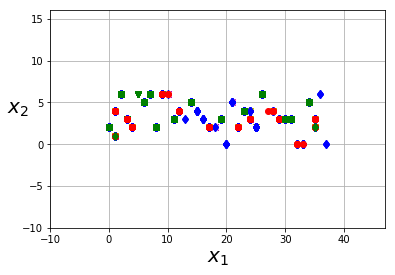

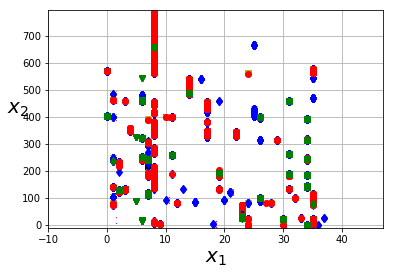

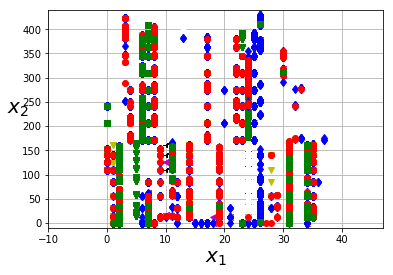

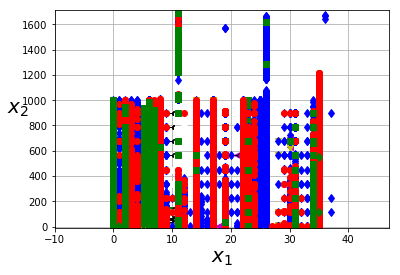

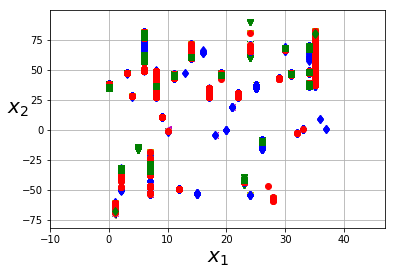

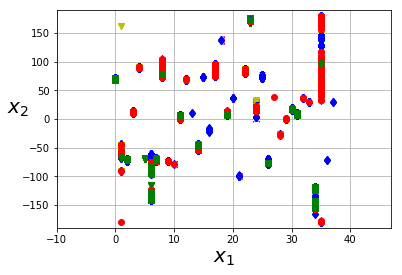

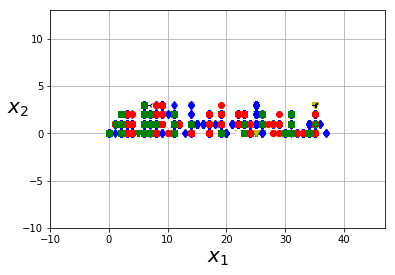

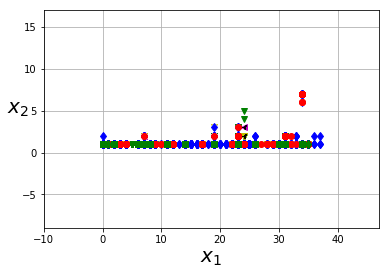

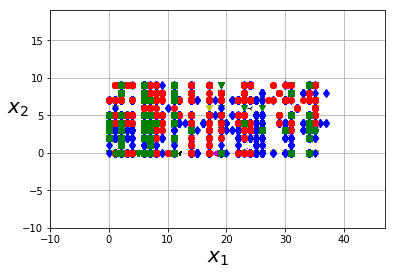

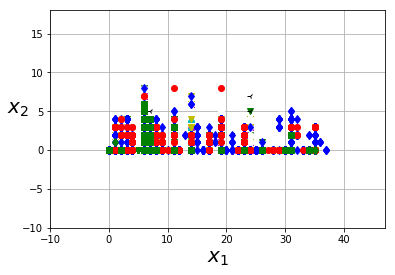

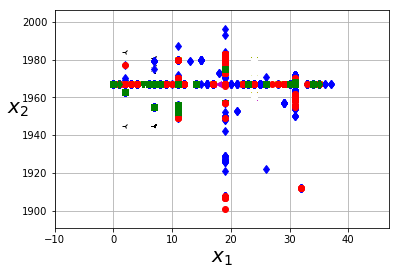

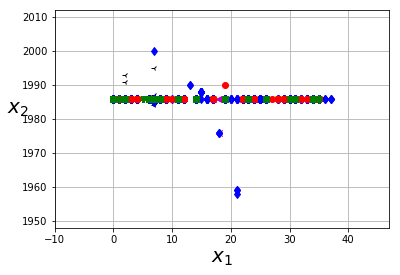

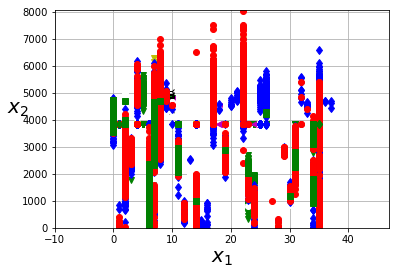

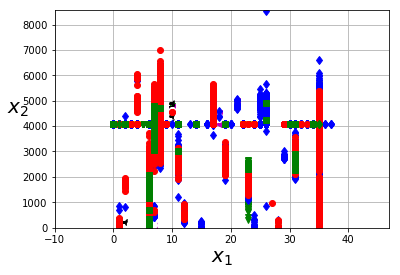

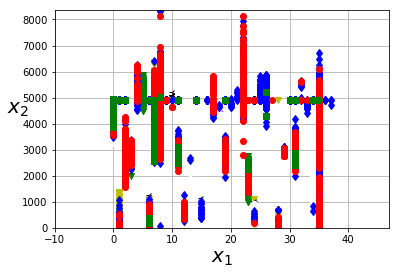

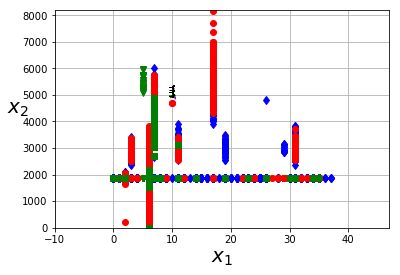

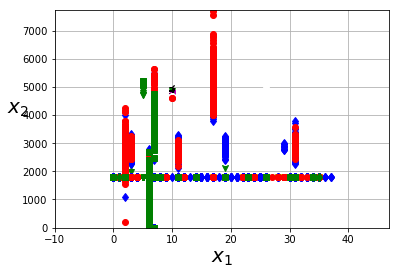

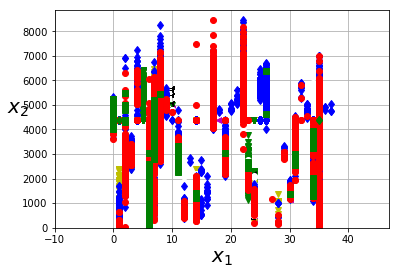

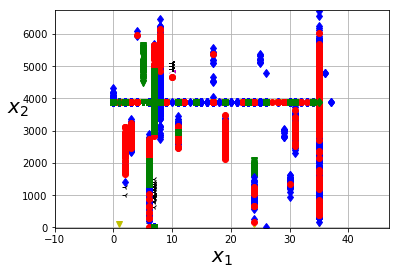

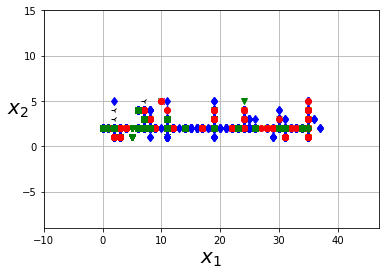

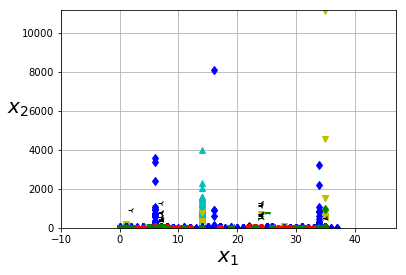

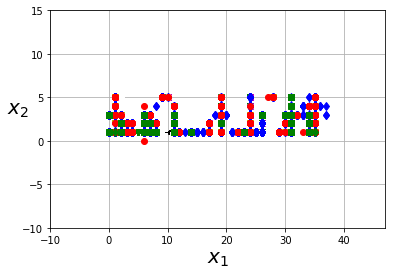

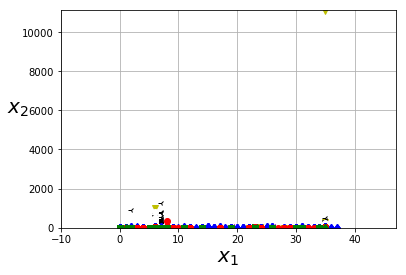

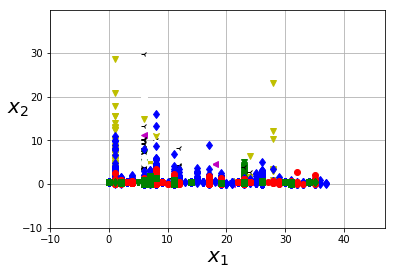

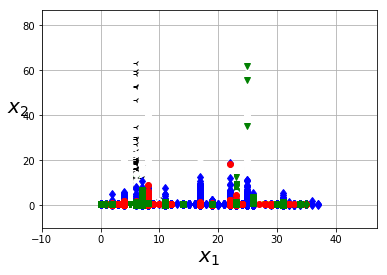

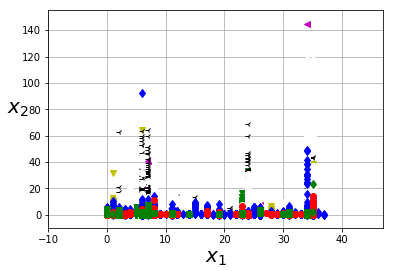

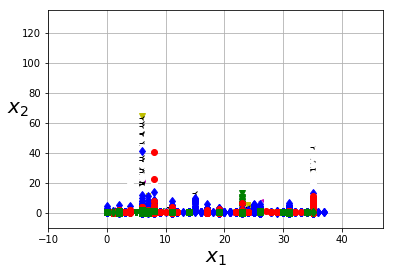

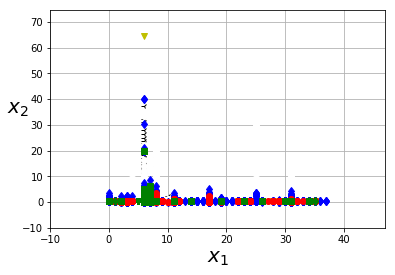

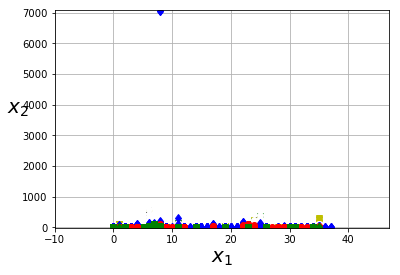

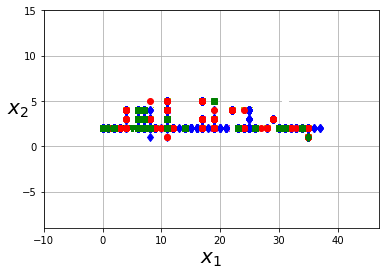

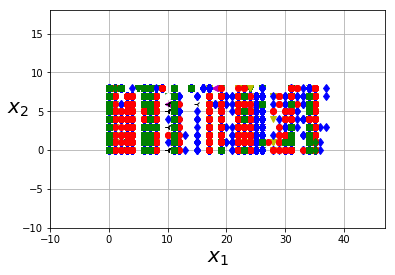

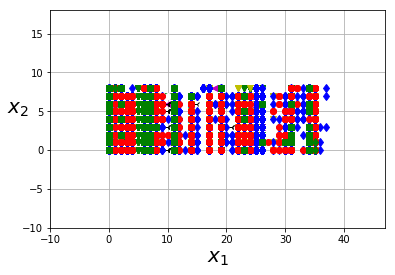

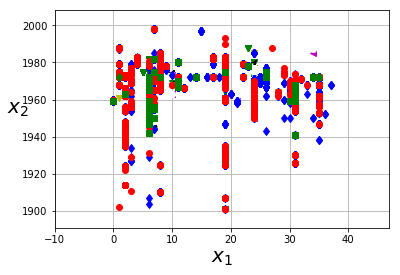

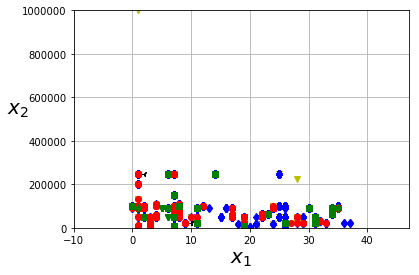

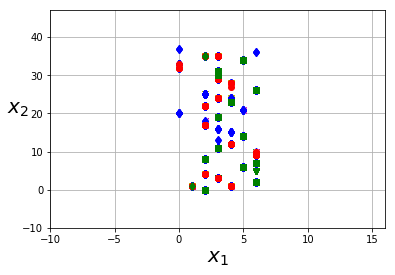

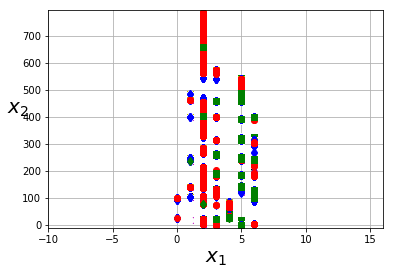

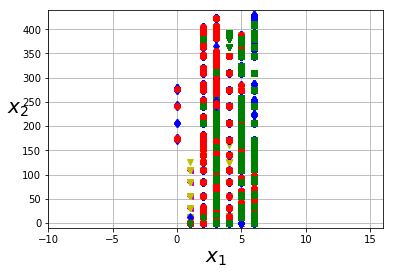

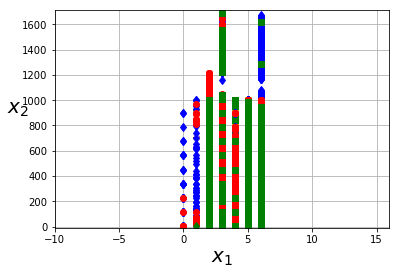

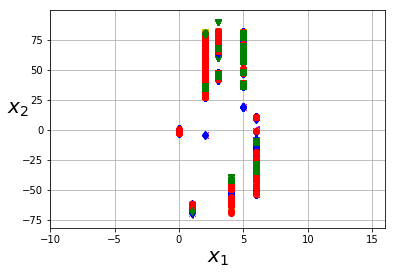

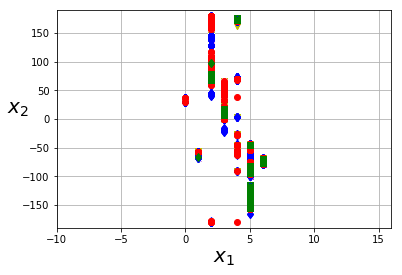

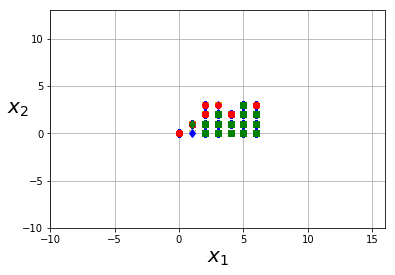

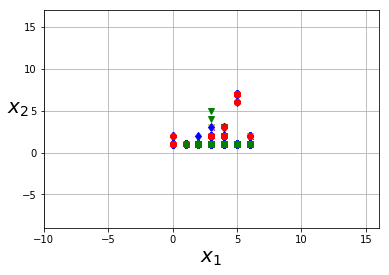

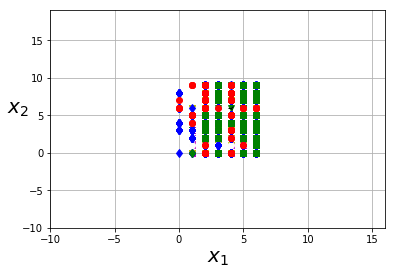

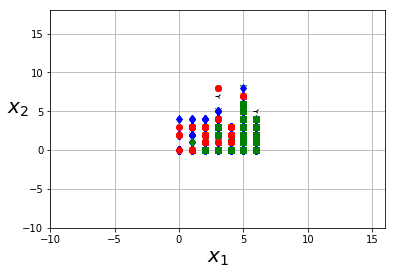

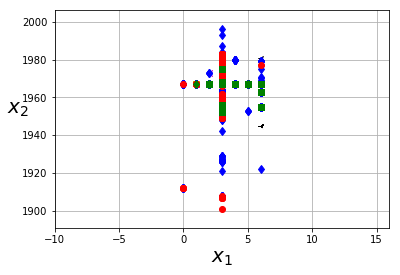

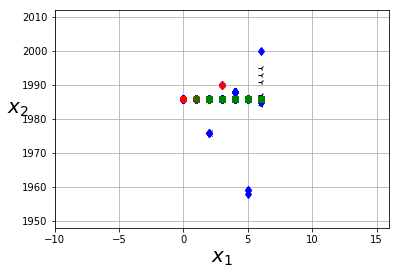

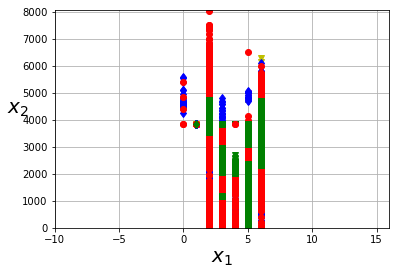

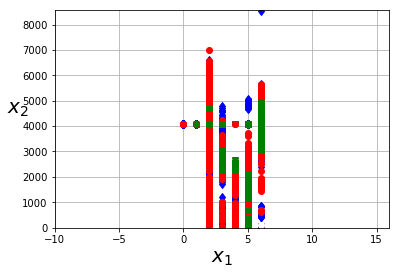

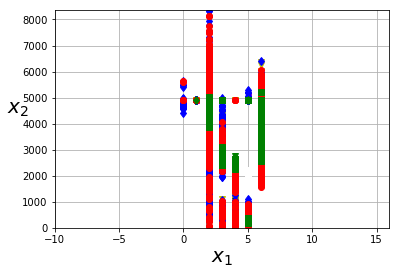

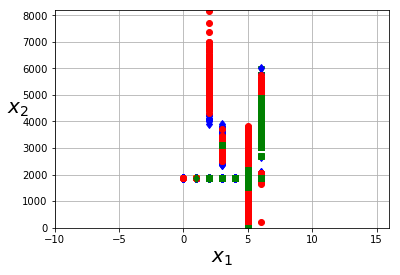

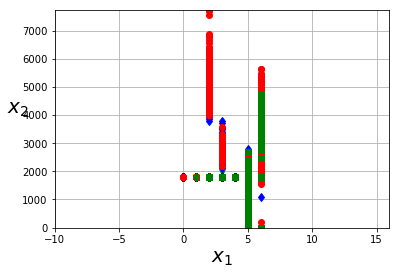

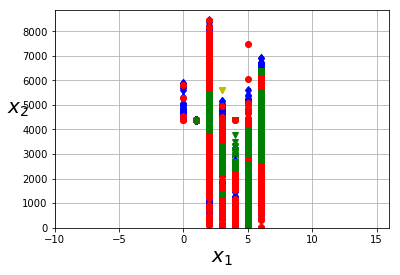

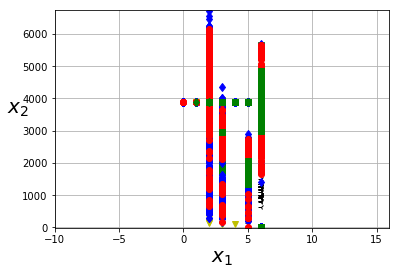

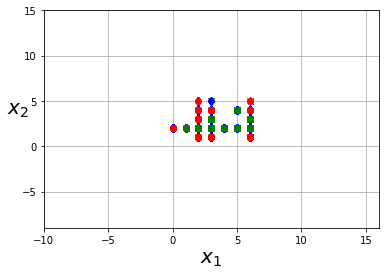

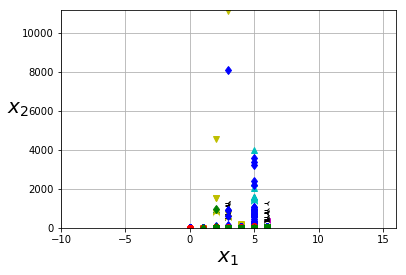

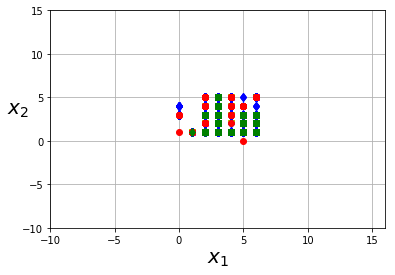

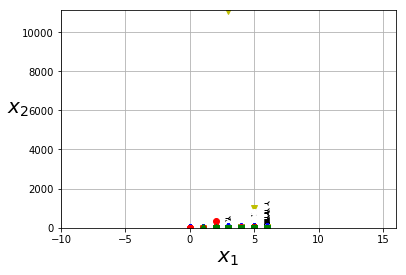

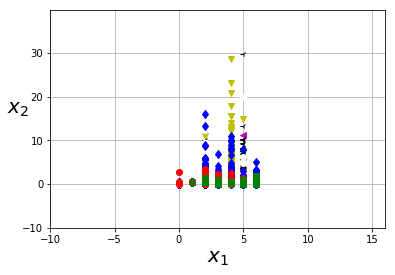

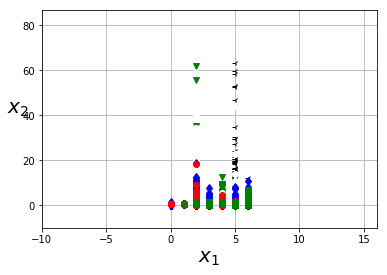

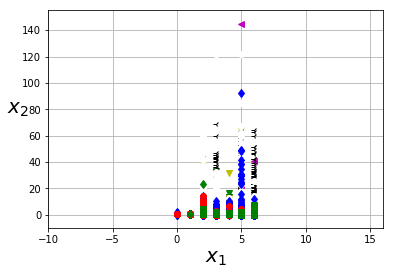

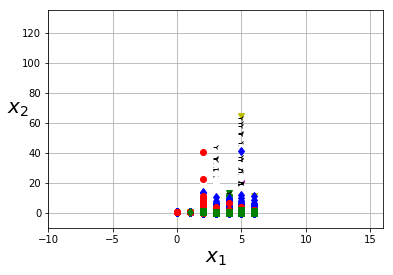

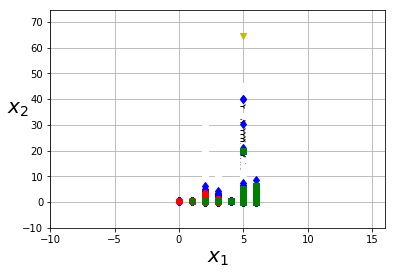

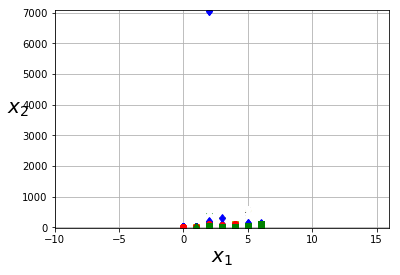

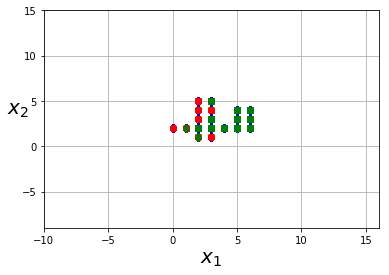

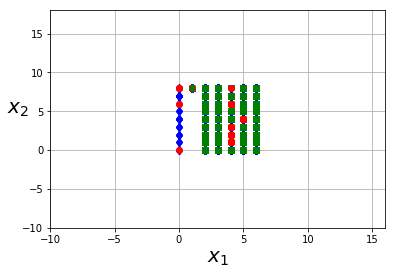

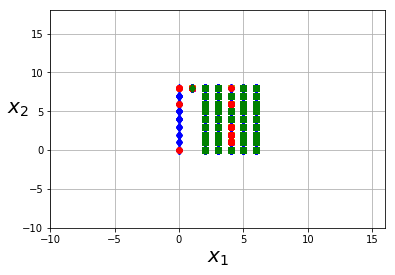

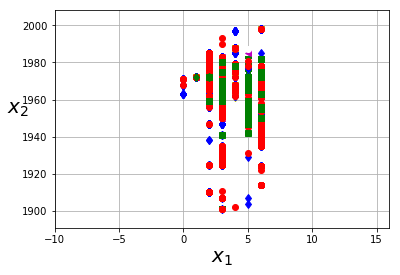

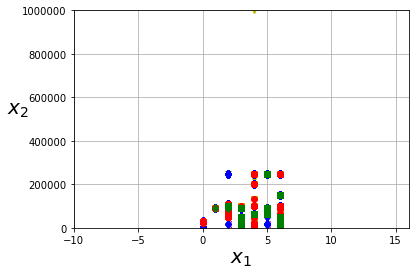

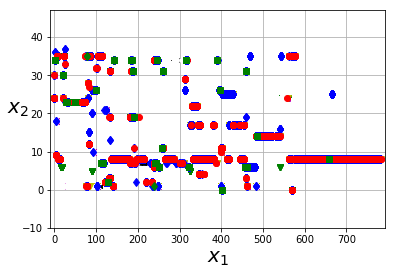

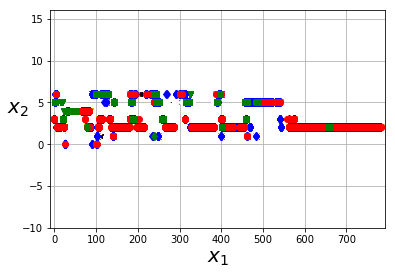

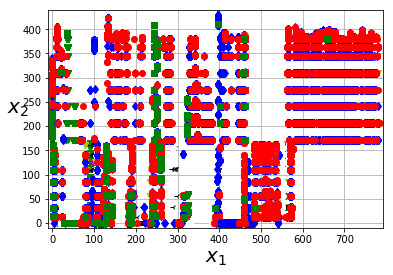

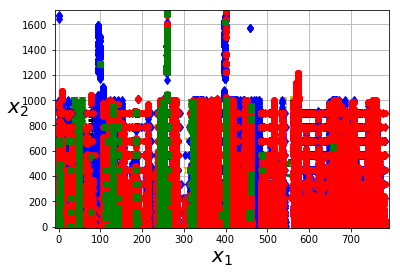

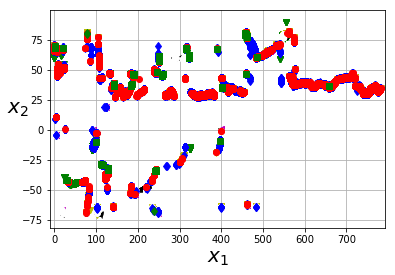

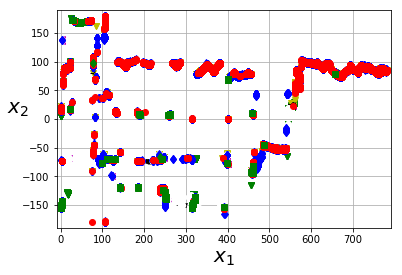

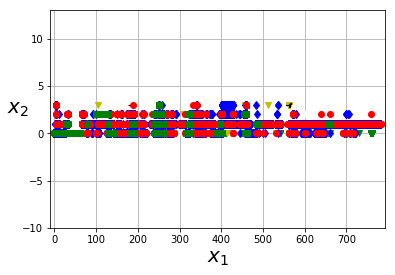

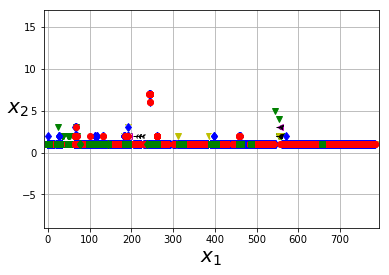

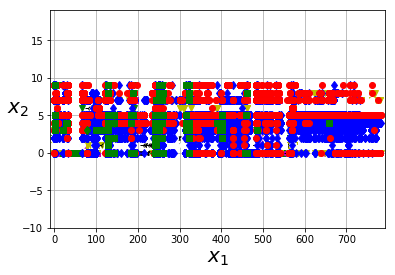

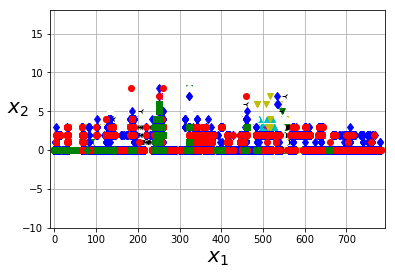

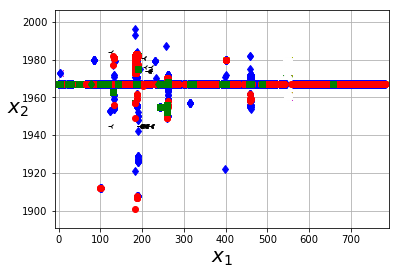

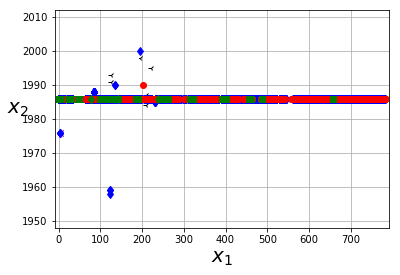

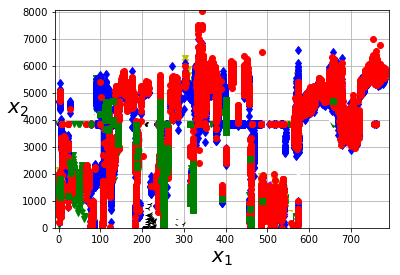

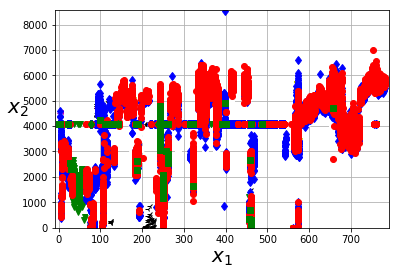

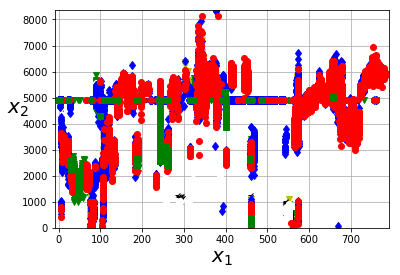

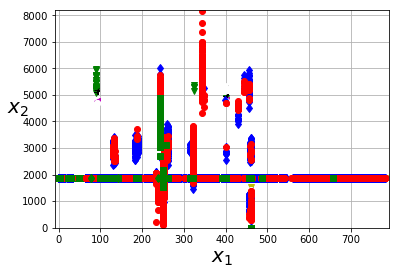

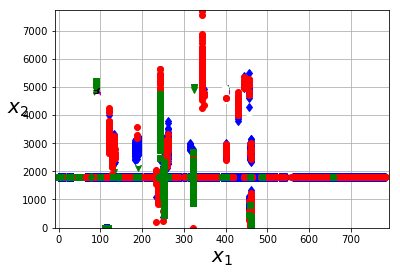

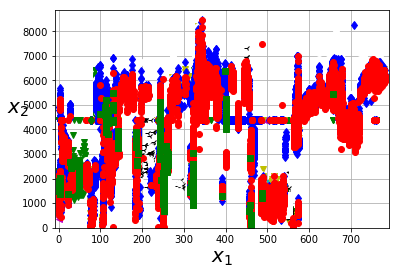

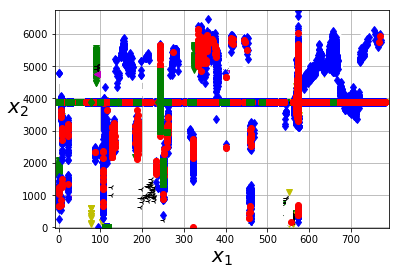

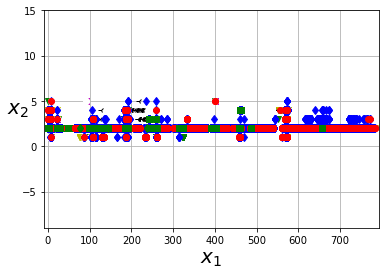

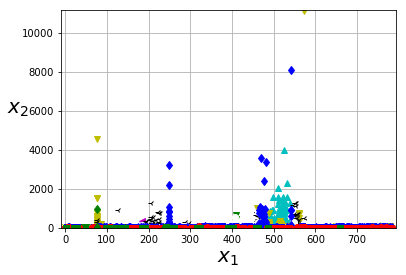

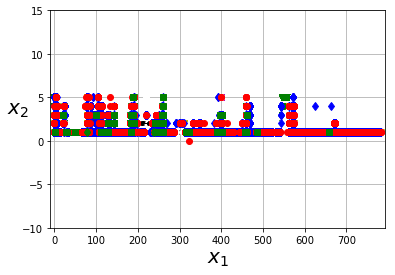

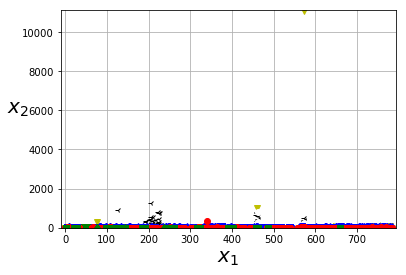

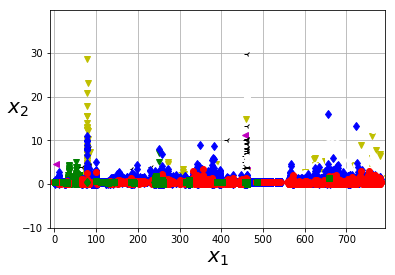

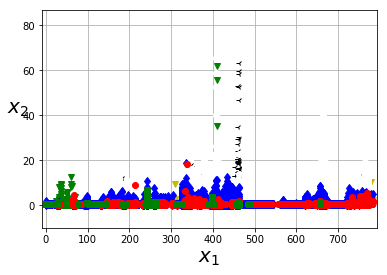

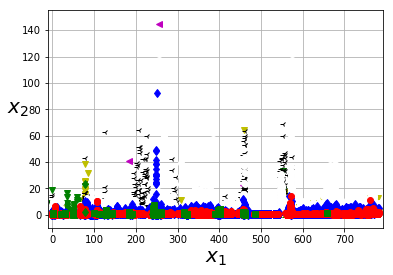

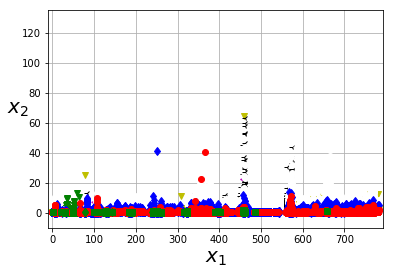

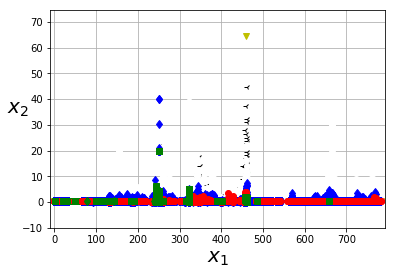

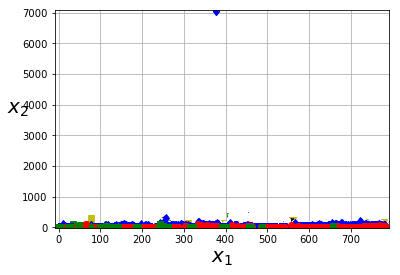

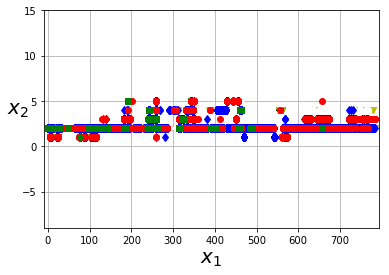

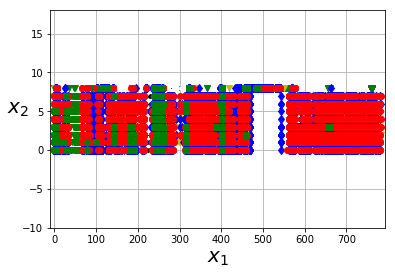

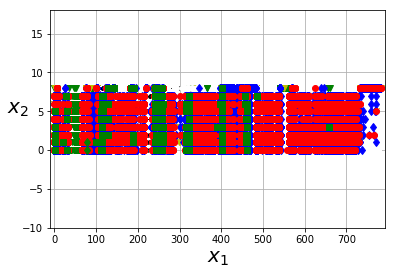

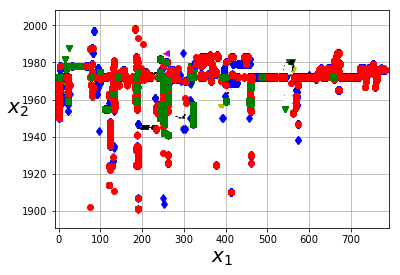

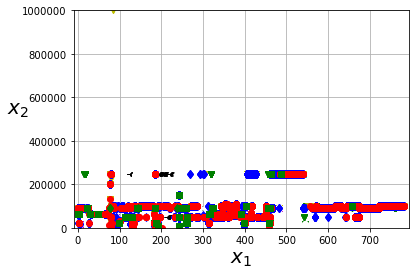

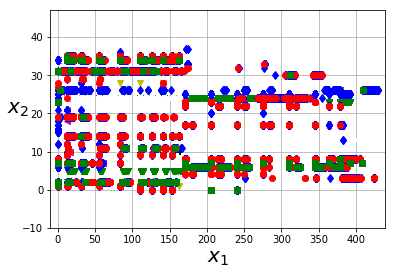

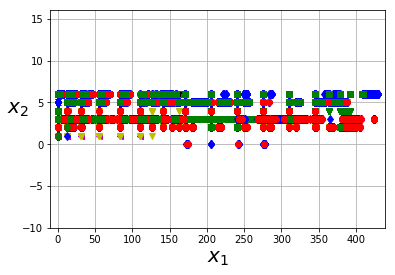

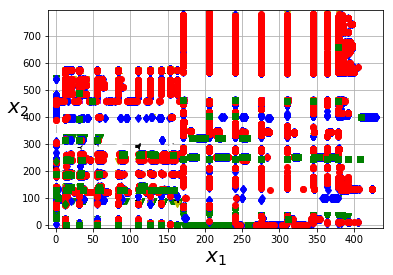

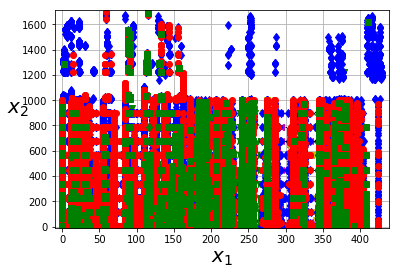

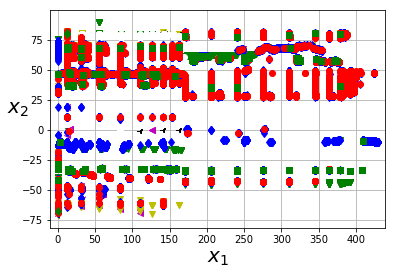

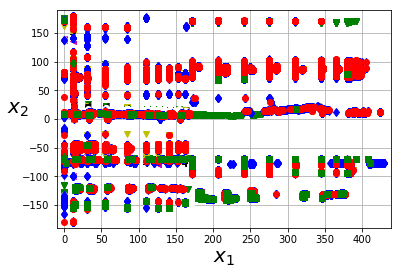

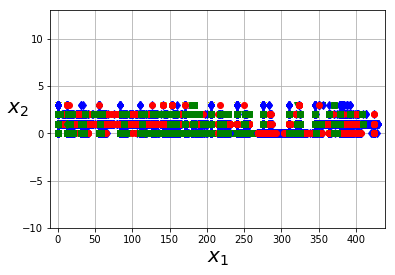

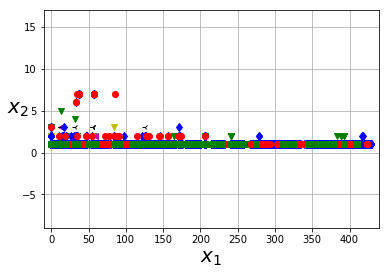

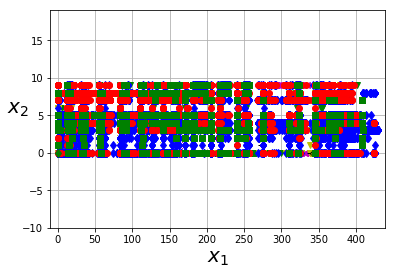

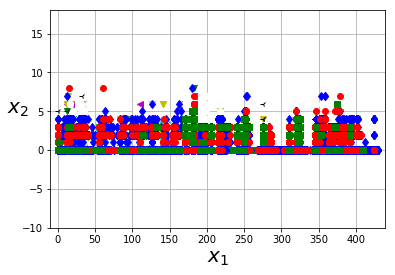

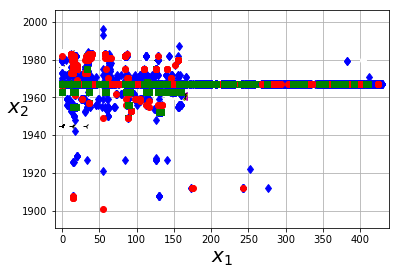

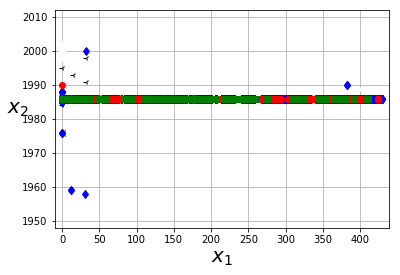

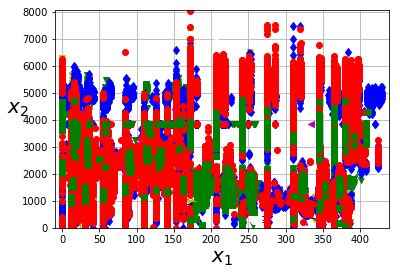

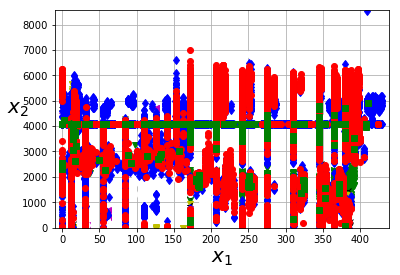

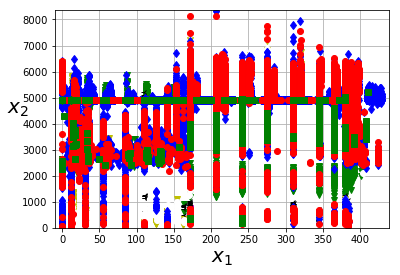

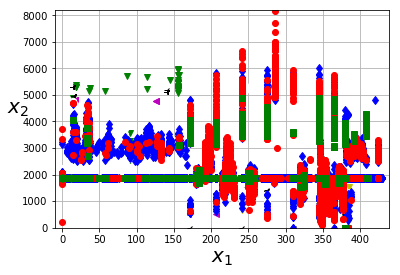

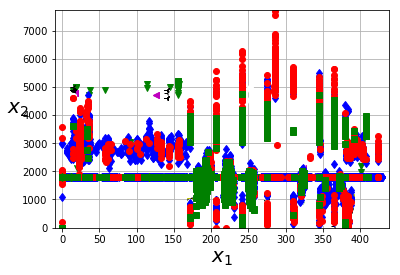

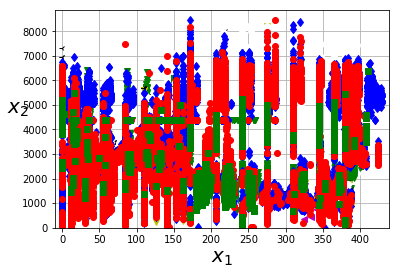

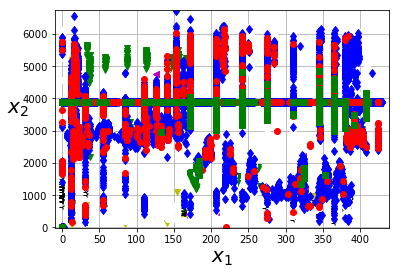

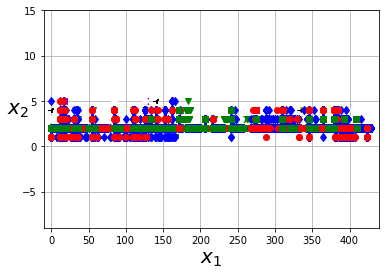

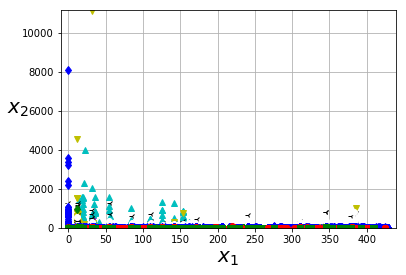

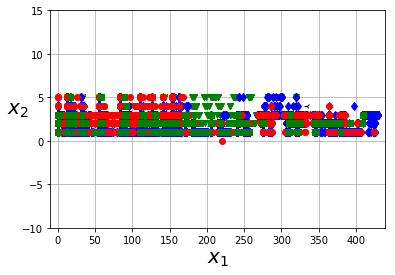

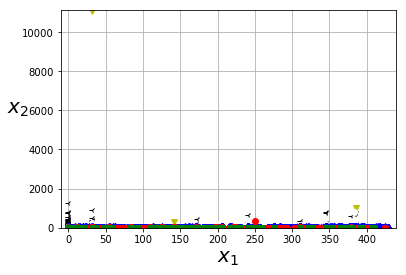

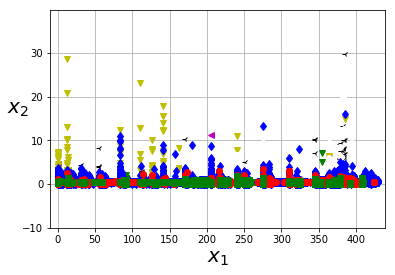

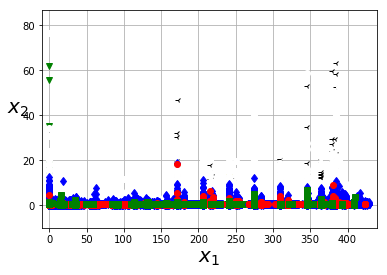

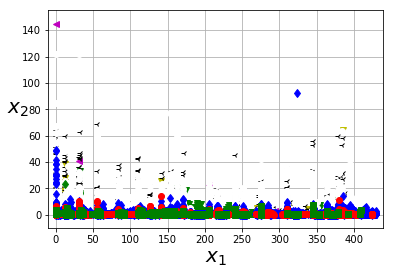

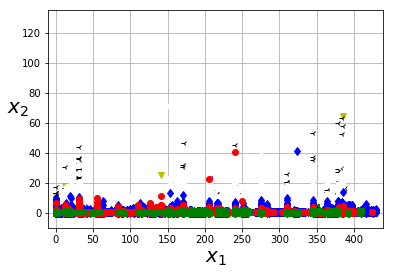

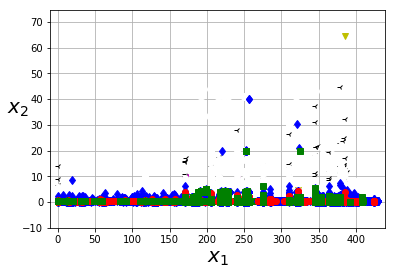

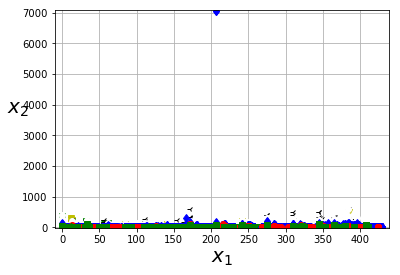

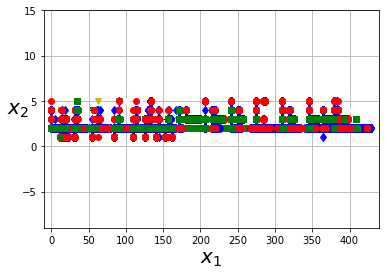

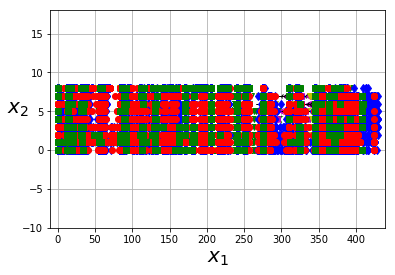

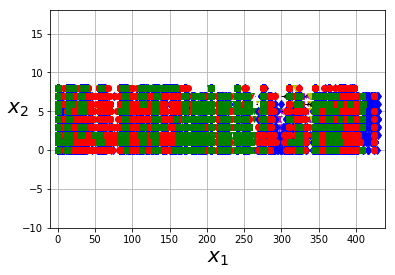

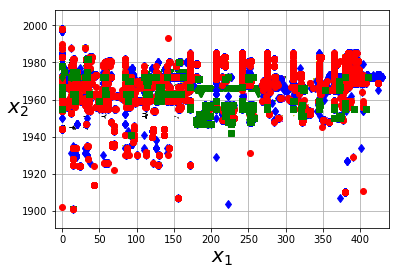

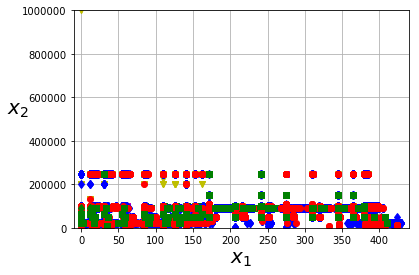

KeyboardInterrupt: 

In [146]:
for temp1 in range(0, length):
    for temp2 in range(0, length):
        if (temp1 == temp2):
            print("")
        else:
            plot_dataset(x_train_copy, y_train_copy, [x_train_copy[:, temp1].min() - 10, x_train_copy[:, temp1].max() + 10, x_train_copy[:, temp2].min() - 10, x_train_copy[:, temp2].max() + 10], temp1, temp2) #Departure time and distance plotted
            plt.show()

# Decision Tree Classifier (1-split)

In [52]:
dt_clf = DecisionTreeClassifier(random_state = 42)

In [53]:
dt_clf.fit(x_train, y_train)
dt_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [54]:
dt_clf.classes_ # verifying that we are using multiple classes

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [57]:
cross_val_score(dt_clf, x_train, y_train, cv = 3, scoring = "accuracy")

array([0.87872803, 0.87828762, 0.87983632])

In [58]:
y_train_predict_dt = cross_val_predict(dt_clf, x_train, y_train, cv = 3)
y_train_predict_dt

array([7., 6., 7., ..., 0., 7., 5.])

In [83]:
# The confusion matrix is a bit different for multi-class problems

confusion_dt = confusion_matrix(y_train, y_train_predict_dt)
confusion_dt

array([[ 6377,     0,     4,     7,    20,    10,    56,    76,     0,
           12],
       [    0,   215,     0,     2,     0,     0,     0,     0,     0,
            0],
       [    2,     0,   219,    67,    17,    34,   118,    72,     0,
            2],
       [   12,     6,    63,  1582,    26,    31,   326,   134,     0,
            3],
       [   25,     0,    17,    37,  1682,   181,    95,    20,     2,
            0],
       [    9,     0,    14,    37,   175,  8523,  2313,    87,     0,
           24],
       [   70,     2,   124,   325,    83,  2371, 47652,  2419,     2,
          169],
       [   56,     0,    94,   134,    18,    87,  2392, 25323,     1,
           77],
       [    0,     0,     0,     1,     2,     0,     1,     0,     0,
            0],
       [   17,     0,     6,     1,     2,    22,   186,    71,     0,
         1870]])

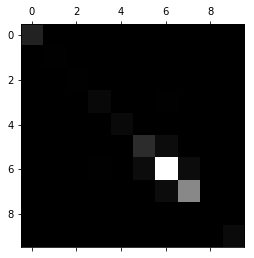

In [85]:
plt.matshow(confusion_dt, cmap = plt.cm.gray)
plt.show()

In [65]:
precision_score(y_train, y_train_predict_dt, average = 'weighted')

0.8790886527165317

In [66]:
recall_score(y_train, y_train_predict_dt, average = 'weighted')

0.8789506358642486

In [67]:
f1_score(y_train, y_train_predict_dt, average = 'weighted')

0.8790163830784185

In [74]:
dt_predictions = dt_clf.predict(x_test) #predict how the classes from our test set
dt_predictions

array([6., 6., 6., ..., 7., 6., 6.])

In [76]:
print(accuracy_score(y_test, dt_predictions)) #88.5% accurate on our test set!!!!

0.885544435247197


# Base performance

Our base performance when using the decision tree classifier is the 87.90% f1 score.

# Bagging Classifier

Now lets take a look at our bagging classifer!

In [78]:
bagg_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, n_jobs = -1)

In [79]:
bagg_clf.fit(x_train, y_train)
bagg_clf

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [80]:
bagg_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [81]:
cross_val_score(bagg_clf, x_train, y_train, cv = 3, scoring = "accuracy")

array([0.76008013, 0.75615194, 0.75992663])

In [82]:
y_train_predict_bagg = cross_val_predict(bagg_clf, x_train, y_train, cv = 3)
y_train_predict_bagg

array([6., 6., 7., ..., 6., 7., 5.])

In [84]:
confusion_bagg = confusion_matrix(y_train, y_train_predict_bagg)
confusion_bagg

array([[ 5626,     0,     0,     0,     0,   115,   735,    85,     0,
            1],
       [    0,     0,     0,     0,     0,     0,   217,     0,     0,
            0],
       [   23,     0,     0,     0,     0,    33,   380,    95,     0,
            0],
       [   80,     0,     0,    25,     3,   341,  1555,   179,     0,
            0],
       [   22,     0,     0,     0,     0,  1066,   950,    21,     0,
            0],
       [    1,     0,     0,     0,     0,  5472,  5662,    47,     0,
            0],
       [   85,     0,     0,     0,     0,  1304, 47701,  4127,     0,
            0],
       [   97,     0,     0,     0,     0,    45,  6141, 21899,     0,
            0],
       [    1,     0,     0,     0,     0,     1,     2,     0,     0,
            0],
       [   22,     0,     0,     0,     0,    45,  1373,   692,     0,
           43]])

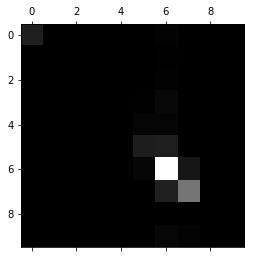

In [86]:
plt.matshow(confusion_bagg, cmap = plt.cm.gray)
plt.show()

In [87]:
precision_score(y_train, y_train_predict_bagg, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7499819639607336

In [90]:
recall_score(y_train, y_train_predict_bagg, average = 'weighted')

0.7597072766950109

In [91]:
f1_score(y_train, y_train_predict_bagg, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.730241138528881

In [92]:
bagg_predictions = bagg_clf.predict(x_test) #predict how the classes from our test set
bagg_predictions

array([6., 7., 6., ..., 7., 6., 6.])

In [93]:
print(accuracy_score(y_test, bagg_predictions)) #88.5% accurate on our test set!!!!

0.754947701106178


# Random Forest Ensemble

In [95]:
random_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)

In [96]:
random_clf.fit(x_train, y_train)
random_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [97]:
random_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [98]:
cross_val_score(random_clf, x_train, y_train, cv = 3, scoring = "accuracy")

array([0.74718546, 0.73882492, 0.74265557])

In [99]:
y_train_predict_random = cross_val_predict(random_clf, x_train, y_train, cv = 3)
y_train_predict_random

array([6., 7., 7., ..., 6., 6., 5.])

In [100]:
confusion_random = confusion_matrix(y_train, y_train_predict_random)
confusion_random

array([[ 5173,     0,     0,     0,     0,    61,  1260,    68,     0,
            0],
       [    0,     0,     0,     0,     0,     0,   217,     0,     0,
            0],
       [    3,     0,     0,     0,     0,    21,   454,    53,     0,
            0],
       [    4,     0,     0,     0,     0,   153,  1910,   116,     0,
            0],
       [    5,     0,     0,     0,     0,   761,  1277,    16,     0,
            0],
       [    2,     0,     0,     0,     0,  4603,  6543,    34,     0,
            0],
       [   73,     0,     0,     0,     0,   941, 48565,  3638,     0,
            0],
       [   93,     0,     0,     0,     0,    10,  7282, 20797,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     4,     0,     0,
            0],
       [    4,     0,     0,     0,     0,     2,  1572,   597,     0,
            0]])

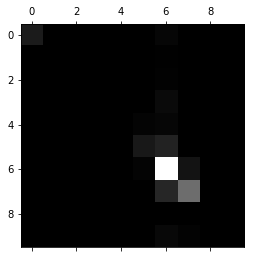

In [101]:
plt.matshow(confusion_random, cmap = plt.cm.gray)
plt.show()

In [103]:
precision_score(y_train, y_train_predict_random, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7031355579728313

In [104]:
recall_score(y_train, y_train_predict_random, average = 'weighted')

0.7443938595831139

In [109]:
f1_score(y_train, y_train_predict_random, average = 'weighted')

/home/shelob/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7118195271981604

In [106]:
random_predictions = random_clf.predict(x_test) #predict how the classes from our test set
random_predictions

array([6., 7., 6., ..., 7., 6., 6.])

In [107]:
print(accuracy_score(y_test, random_predictions)) #88.5% accurate on our test set!!!!

0.7406125366844759


# Adaboost Classifier

In [110]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = .5)

In [112]:
ada_clf.fit(x_train, y_train)
ada_clf

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

In [113]:
ada_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [114]:
cross_val_score(ada_clf, x_train, y_train, cv = 3, scoring = "accuracy")

array([0.35729804, 0.3355627 , 0.37186398])

In [115]:
y_train_predict_ada = cross_val_predict(ada_clf, x_train, y_train, cv = 3)
y_train_predict_ada

array([7., 6., 7., ..., 7., 0., 0.])

In [116]:
confusion_ada = confusion_matrix(y_train, y_train_predict_ada)
confusion_ada

array([[ 4435,     0,     4,   696,   300,     6,   155,   506,     0,
          460],
       [    0,    78,    42,    96,     0,     0,     1,     0,     0,
            0],
       [  105,     2,    27,    26,    77,    29,   168,    75,     0,
           22],
       [  292,     8,    54,   267,   413,    73,   742,   284,     0,
           50],
       [  445,     0,    13,    82,  1243,   121,    98,    32,     0,
           25],
       [ 2178,     0,    13,   274,  3270,  2838,  1443,   244,     0,
          922],
       [ 9626,     0,    58,  4433,  4737,  3450, 18542,  5329,     0,
         7042],
       [ 4555,     0,    38,  1031,   631,    95,  4640,  9006,     0,
         8186],
       [    1,     0,     0,     0,     3,     0,     0,     0,     0,
            0],
       [  573,     0,     0,     1,    92,     6,    86,   122,     0,
         1295]])

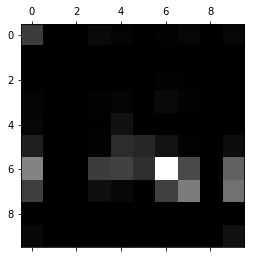

In [117]:
plt.matshow(confusion_ada, cmap = plt.cm.gray)
plt.show()

# Ranking Feature Importance

Next, we'll see how the Random Forest Classifier ranked each feature in terms of relative importance!

In [123]:
# Let's take a look at the raw feature importance's

random_clf.feature_importances_

array([4.30075054e-02, 2.43244159e-02, 4.02964329e-02, 5.57752557e-03,
       5.20280072e-04, 5.84919634e-02, 4.16049271e-02, 1.15318447e-02,
       0.00000000e+00, 1.62301662e-01, 1.97807649e-03, 3.91423601e-04,
       0.00000000e+00, 2.32439637e-02, 1.68351410e-02, 1.13261484e-02,
       1.40515133e-04, 5.33584370e-05, 7.81980756e-03, 6.89463129e-03,
       0.00000000e+00, 1.07777518e-01, 1.28243131e-02, 6.33260125e-02,
       3.60975759e-02, 1.48147977e-02, 5.81135623e-02, 2.90960014e-02,
       8.69640268e-03, 1.18364676e-01, 1.13007854e-02, 3.04365501e-02,
       1.04877132e-02, 1.89921887e-02, 1.12119587e-02, 1.21203212e-02])

In [130]:
# Now let's make it easier for the user to view

for name, score in zip(list(x_train), random_clf.feature_importances_):
    print(name, score)

Political Unit 0.04300750536820756
Continent 0.02432441590020073
Basin Code 0.04029643288164787
Location Code 0.005577525566282263
Glacier Code 0.0005202800716352326
Latitude 0.058491963421434215
Longitude 0.04160492714198571
Glacier Source 0.011531844670285599
Basin Count 0.0
Glacier Form 0.16230166225445258
Glacier Activity 0.0019780764854723538
Activity Start 0.0003914236012680397
Activity End 0.0
Minimum Elevation 0.02324396369707667
Minimum Elevation Exposed 0.016835140987203005
Mean Elevation 0.011326148430791626
Mean Elevation Accumulation 0.0001405151332363349
Mean Elevation Ablation 5.335843697854742e-05
Maximum Elevation 0.007819807561057612
Snow Line Elevation 0.006894631290244675
Snow Line Accuracy 0.0
Glacier Area 0.10777751781483987
Area Accuracy 0.012824313112433249
Area Exposed 0.06332601249742006
Mean Width 0.036097575897506035
Mean Length 0.01481479769483337
Maximum Length 0.058113562331736916
Maximum Length Exposed 0.029096001403723513
Maximum Length Ablation 0.00869

# Everything below will probably not be used except the headings for the sections

In [6]:
test = glacier_data.loc[glacier_data["Maximum Elevation"] == glacier_data["Maximum Elevation"].max()] #.max() = 8848

#Just a test add

In [7]:
test["Maximum Elevation"]

33514    8848.0
33755    8848.0
Name: Maximum Elevation, dtype: float64

In [8]:
test

,Glacier ID,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Glacier Name,Latitude,Longitude,Primary Class,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
33514,CN5O192BA059,CHINA,ASIA,O192,BA,59,KANGXIONG,27.986,87.001,5.0,...,27.2,2.8,8.8,177.0,2.0,SE,E,1980.0,100000.0,1974.0
33755,CN5O192BB142,CHINA,ASIA,O192,BB,142,RONGBU,28.049,86.833,5.0,...,22.4,16.6,16.8,191.0,2.0,N,NW,1980.0,50000.0,1974.0


In [9]:
#Taking a look at what years are represented in chronological order

glacier_data["Continent"].value_counts().sort_index()

AFRICA                                  59
ANTARCTICA                             957
ASIA                                 81245
EUROPE                               12889
NEW ZEALAND AND ANTARCTIC ISLANDS     3704
NORTH AMERICA                        24689
SOUTH AMERICA                         9347
Name: Continent, dtype: int64

In [10]:
test2 = glacier_data.loc[glacier_data["Continent"] == "AFRICA"]

In [11]:
test2.head(59)

,Glacier ID,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Glacier Name,Latitude,Longitude,Primary Class,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
87016,KE3D300B0001,KENYA,AFRICA,D300,B0,1,KOLBE,-0.153,37.318,6.0,...,0.3,NaN,NaN,NaN,NaN,NE,NE,1964.0,25000.0,NaN
87017,KE3D300B0002,KENYA,AFRICA,D300,B0,2,KRAPF,-0.150,37.310,6.0,...,0.4,NaN,NaN,NaN,NaN,N,N,1963.0,5000.0,NaN
87018,KE3D300B0003,KENYA,AFRICA,D300,B0,3,NORTHEY,-0.148,37.307,6.0,...,0.3,NaN,NaN,NaN,NaN,NW,NE,1963.0,5000.0,NaN
87019,KE3D300B0004,KENYA,AFRICA,D300,B0,4,JOSEF,-0.147,37.304,6.0,...,0.2,NaN,NaN,NaN,NaN,N,N,1963.0,5000.0,NaN
87020,KE3D300B0005,KENYA,AFRICA,D300,B0,5,CESAR,-0.147,37.304,6.0,...,0.4,NaN,NaN,NaN,NaN,W,W,1963.0,5000.0,NaN
87021,KE3D300B0006,KENYA,AFRICA,D300,B0,6,GREGORY,-0.152,37.315,6.0,...,0.4,NaN,NaN,NaN,NaN,N,N,1963.0,5000.0,NaN
87022,KE3D300D0001,KENYA,AFRICA,D300,D0,1,LEWIS,-0.157,37.312,6.0,...,0.9,NaN,NaN,NaN,NaN,SW,SW,1963.0,5000.0,NaN
87023,KE3D300D0002,KENYA,AFRICA,D300,D0,2,TYNDALL,-0.152,37.304,6.0,...,0.6,NaN,NaN,NaN,NaN,W,S,1963.0,5000.0,NaN
87024,KE3D300D0003,KENYA,AFRICA,D300,D0,3,HEIM,-0.152,37.305,6.0,...,0.1,NaN,NaN,NaN,NaN,SW,SW,1963.0,5000.0,NaN
87025,KE3D300D0004,KENYA,AFRICA,D300,D0,4,FOREL,-0.151,37.307,6.0,...,0.2,NaN,NaN,NaN,NaN,W,NW,1963.0,5000.0,NaN


In [12]:
glacier_data["Political Unit"].value_counts().sort_index()

AFGHANISTAN                            610
ANTARCTICA                            1297
ARGENTINA                             2648
AUSTRIA                                925
BHUTAN                                 689
BOLIVIA                               1687
CANADA                               16731
CHILE                                 1743
CHINA                                45616
COLOMBIA                               106
ECUADOR                                113
FRANCE                                1114
FRENCH SOUTHERN TERRITORIES            145
GERMANY                                  5
GREENLAND                             5299
HEARD ISLAND AND MCDONALD ISLANDS       31
ICELAND                                 16
INDIA                                 4952
INDONESIA                                8
ITALY                                 1540
KENYA                                   13
MEXICO                                  23
NEPAL                                 3249
NEW ZEALAND

In [13]:
test3 = glacier_data.loc[glacier_data["Political Unit"] == "SOUTH GEORGIA"]

In [14]:
test3.head(20)

,Glacier ID,Political Unit,Continent,Basin Code,Location Code,Glacier Code,Glacier Name,Latitude,Longitude,Primary Class,...,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Accumulation Orientation,Ablation Orientation,Topographic Map Year,Topographic Map Scale,Photograph Year
80440,GS6C20300001,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,0,1,NaN,-56.300,-27.569,7.0,...,0.22,NaN,NaN,NaN,NaN,SE,SE,1962.0,50000.0,NaN
80441,GS6C20302001,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,1,NaN,-56.692,-27.151,6.0,...,2.63,NaN,NaN,NaN,NaN,NE,N,1962.0,51000.0,NaN
80442,GS6C20302002,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,2,NaN,-56.699,-27.141,3.0,...,4.61,NaN,NaN,NaN,NaN,E,E,1962.0,51000.0,NaN
80443,GS6C20302003,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,3,NaN,-56.711,-27.143,6.0,...,4.52,NaN,NaN,NaN,NaN,E,SE,1962.0,51000.0,NaN
80444,GS6C20302004,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,4,NaN,-56.715,-27.154,6.0,...,3.06,NaN,NaN,NaN,NaN,SE,S,1962.0,51000.0,NaN
80445,GS6C20302005,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,5,NaN,-56.718,-27.166,6.0,...,1.62,NaN,NaN,NaN,NaN,S,S,1962.0,51000.0,NaN
80446,GS6C20302006,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,6,NaN,-56.717,-27.178,6.0,...,1.74,NaN,NaN,NaN,NaN,SW,SW,1962.0,51000.0,NaN
80447,GS6C20302007,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,2,7,NaN,-56.704,-27.182,6.0,...,1.70,NaN,NaN,NaN,NaN,W,W,1962.0,51000.0,NaN
80448,GS6C20303001,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,3,1,NaN,-57.075,-26.657,6.0,...,0.47,NaN,NaN,NaN,NaN,E,E,1964.0,25000.0,NaN
80449,GS6C20303002,SOUTH GEORGIA,NEW ZEALAND AND ANTARCTIC ISLANDS,C203,3,2,NaN,-57.081,-26.656,6.0,...,0.42,NaN,NaN,NaN,NaN,E,E,1964.0,25000.0,NaN


### Non-linear Separation Visualization

((Is there any non-linearly separation among the classes in your dataset))

### Select a Base Classifier

((LinearRegression OR Decision Tree (1 split) and get F-1 score ))

### Select a few options of ensemble train and measure them

((Must have bagging, random forest, Adaboost))
((For each: Confusion Matrix, Precision and recall, F-1 score, ROC Curve, Area under ROC))

((Which yeilds best results))

### Rank Feature Importance

((using Random Forest to rank the importance (usefulness) of the features in your dataset))

### Present Solution

### Plan for the Future

((need more data?))
((Does it work for the future?))
((Satisfied with system?))